## This notebooks show the performance with different set of features at different stations.

In [3]:
## importing the necessary dependencies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib

from obspy.geodetics.base import gps2dist_azimuth
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from tsfel import time_series_features_extractor

import tsfel
#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

In [4]:
# Loading metadata information

## importing station and event metadata



iq_lats = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Catalogs/icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Catalogs/icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Catalogs/earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Catalogs/earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])




stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278  ## coordinates of Columbia glacier. 

In [5]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('../Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('../Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events) ## To order the station-wise results according to total number of events recorded

### The following cell defines two functions. One functions is simple random forest function, other one is the random function but when each class has equal number of samples. This is just to test the sensitivity of specific set of features to the class imbalance. 

In [6]:
## We will define all the functions used in subsequent analysis in this cell. 


def forest_test(X, Y, n_estimators= 100):
    
    """
    This function applies Random Forest classification on the input X[n_samples, n_features] and corresponding
    labels y. It will split X into test and training according to ratio specified and output the accuracy,
    sensitivity and specificity. 
    n_estimators - number of decision trees
    Other parameters of random forests are same as in default model. 
    dur - refers to the time it took to train the model
    """
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.33, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    
    tn, fp, fn, tp = confusion_matrix(Y_Test, predictionforest).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc, sensitivity, specificity, dur



## Forest test for balanced data.

def forest_test_balanced(X, Y, n_estimators= 100):
    
    """
    This function applies Random Forest classification on the input X[n_samples, n_features] and corresponding
    labels y. It will split X into test and training according to ratio specified and output the accuracy,
    sensitivity and specificity. 
    n_estimators - number of decision trees
    
    dur - refers to the time it took to train the model
    """
    
    n_iq = len(np.where(Y == 1)[0])
    n_eq = len(np.where(Y == 0)[0])
    
    print('No of Icequakes:'+str(n_iq))
    print('No of Earthquakes:'+str(n_eq))
    
    
    ## Balancing the samples in each class. 
    
    bal = min(n_iq, n_eq)
    iq_start = Y[np.where(Y==1)[0][0]:int(bal+np.where(Y == 1)[0][0])]
    eq_start = Y[np.where(Y==0)[0][0]:int(bal+np.where(Y == 0)[0][0])]
    
    iq_feature = X[np.where(Y == 1)[0][0]:int(bal+np.where(Y == 1)[0][0])]
    eq_feature = X[np.where(Y==0)[0][0]:int(bal+np.where(Y == 0)[0][0])]
    
    print('Icequakes:'+str(len(iq_start)))
    print('Earthquakes:'+str(len(eq_start)))
    
    
    Y = np.concatenate([iq_start, eq_start])
    X = np.concatenate([iq_feature, eq_feature])
    
    
    #print(Y)
    #print(X)
    
    #print(len(Y))
    #print(len(X))
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.33, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    

    
    
    
    
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    
    tn, fp, fn, tp = confusion_matrix(Y_Test, predictionforest).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    acc = accuracy_score(Y_Test, predictionforest)
    
    #print(acc)
    #print(sensitivity)
    #print(specificity)
    #print(dur)
    
    return acc, sensitivity, specificity, dur





## Extracting specific kind of features within tsfel library

In [7]:
## Extracting statistical features. 
cfg_file = tsfel.get_features_by_domain('statistical')
stat_features = time_series_features_extractor(cfg_file, np.arange(100), fs= 50,).columns.values


## Extracting temporal features
cfg_file = tsfel.get_features_by_domain('temporal')
temp_features = time_series_features_extractor(cfg_file, np.arange(100), fs= 50,).columns.values

## Extracting temporal features
cfg_file = tsfel.get_features_by_domain('spectral')
spec_features = time_series_features_extractor(cfg_file, np.arange(100), fs= 50,).columns.values



*** Feature extraction started ***
16


*** Feature extraction started ***
18


*** Feature extraction started ***
26


In [8]:
## Computing the accuracy, sensitivity, specificity and duration across different feature types of 1 minute in duration. 



acc_spec = []
sens_spec = []
speci_spec = []
dur_spec = []


acc_temp = []
sens_temp = []
speci_temp = []
dur_temp = []

acc_stat = []
sens_stat = []
speci_stat = []
dur_stat = []

acc_all = []
sens_all = []
speci_all = []
dur_all = []

acc_afs = []
sens_afs = []
speci_afs = []
dur_afs = []


acc_phy = []
sens_phy = []
speci_phy = []
dur_phy = []


for i in tqdm(range(len(stations))):
    
    # Extract statistical features
    X1 = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Tsfel_features_1_25_'+stations[i]+'.csv')
    y1 = X1['label']
    
    X_stat = X1.loc[:,stat_features]
    o1, o2, o3, o4 = forest_test(X_stat, y1)
    acc_stat.append(o1)
    sens_stat.append(o2)
    speci_stat.append(o3)
    dur_stat.append(o4)
    
    
    # Extract temporal features
    X_temp = X1.loc[:,temp_features]
    o1, o2, o3, o4 = forest_test(X_temp, y1)
    acc_temp.append(o1)
    sens_temp.append(o2)
    speci_temp.append(o3)
    dur_temp.append(o4)
    
    # Extract spectral features
    X_spec = X1.loc[:, spec_features]
   
    o1, o2, o3, o4 = forest_test(X_spec, y1)
    acc_spec.append(o1)
    sens_spec.append(o2)
    speci_spec.append(o3)
    dur_spec.append(o4)
    
    
    ## Stacking all features
    X = X1.drop(['label','serial_no'], axis = 1).dropna(axis = 1)
    o1, o2, o3, o4 = forest_test(X, y1)
    acc_all.append(o1)
    sens_all.append(o2)
    speci_all.append(o3)
    dur_all.append(o4)
    
    Xr = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/spectrum_features/Z/spectrum_features_1minute/Z_1_25/"+stations[i]+".txt")
    yr = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/spectrum_features/Z/spectrum_features_1minute/Z_1_25/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(Xr, yr)
    acc_afs.append(o1)
    sens_afs.append(o2)
    speci_afs.append(o3)
    dur_afs.append(o4)
    
    
    Xp = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Physical_features_1_25_'+stations[i]+'.csv')
    yp = Xp['label']
    Xp = Xp.drop(['label','serial_no'], axis = 1).dropna(axis = 1)
    
    
    # Replace infinite values with a large finite value
    Xp.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)

    # Alternatively, you can drop rows with NaN or infinite values
    Xp = Xp.replace([np.inf, -np.inf], np.nan).dropna()

    
    scaler = StandardScaler()
    
    feature_columns = Xp.columns
    X_scaled = scaler.fit_transform(Xp)
    X_stand = pd.DataFrame(X_scaled, columns=feature_columns).dropna(axis = 1)
    
    o1, o2, o3, o4 = forest_test(X_stand, yp)
    acc_phy.append(o1)
    sens_phy.append(o2)
    speci_phy.append(o3)
    dur_phy.append(o4)
    

  0%|          | 0/15 [00:00<?, ?it/s]/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
  7%|▋         | 1/15 [00:02<00:31,  2.23s/it]/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in

 80%|████████  | 12/15 [02:12<00:35, 11.93s/it]/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
 87%|████████▋ | 13/15 [02:31<00:27, 13.82s/it]/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow enco

In [9]:
### run this cell to load distances, SNR and Az values for individual stations. 
dist = []
snr = []
az = []

for i in tqdm(range(len(stations))):
    dist.append(np.loadtxt("../event_parameters/"+stations[i]+"_dist.txt"))
    snr.append(np.loadtxt("../event_parameters/"+stations[i]+"_snr.txt"))
    az.append(np.loadtxt("../event_parameters/"+stations[i]+"_az.txt"))

dist_array = [np.nanmedian(dist[i]) for i in range(len(dist))]
snr_array = [np.nanmedian(snr[i]) for i in range(len(snr))]
az_array = [np.nanmedian(az[i]) for i in range(len(az))]

100%|██████████| 15/15 [00:00<00:00, 265.01it/s]


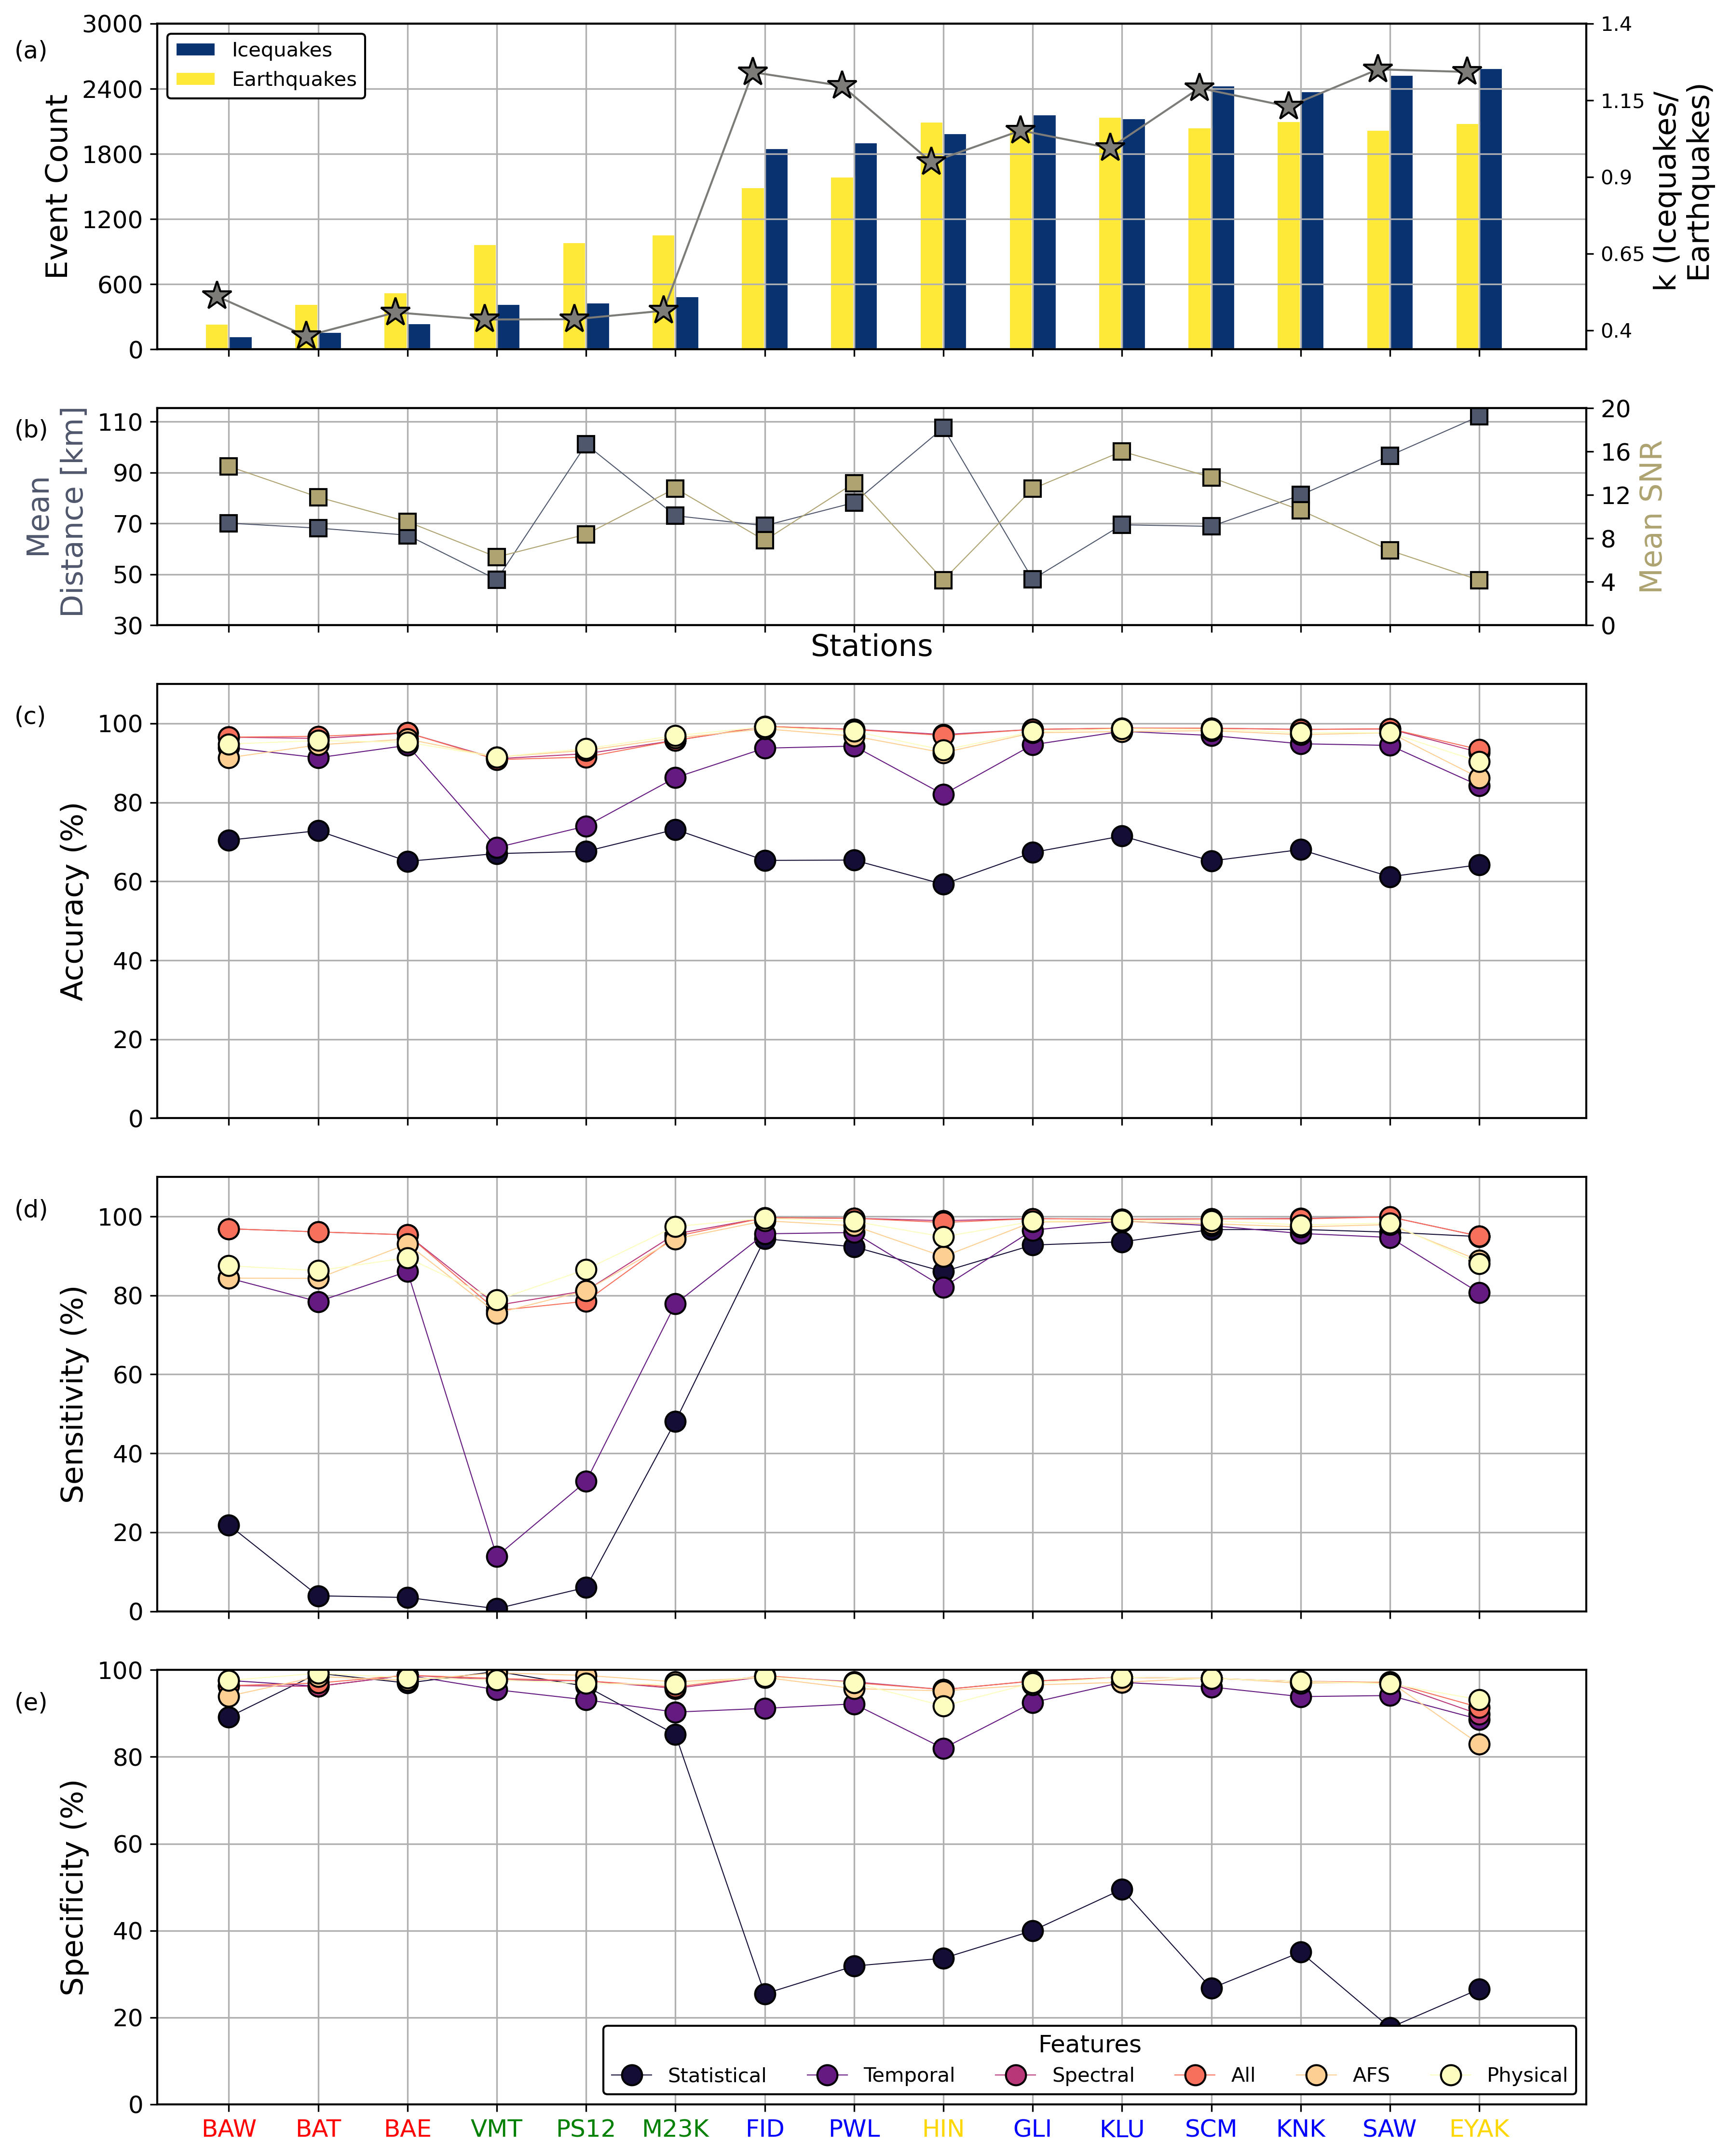

In [43]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 1

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12,15), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1.5,1,2,2,2]}, facecolor ='white', dpi = 300)


# Add labels to subplots
labels = ['(a)', '(b)', '(c)', '(d)','(e)']
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 0.95, labels[i], transform=ax.transAxes,
            fontsize=12, va='top')

(ax,ax1, ax2, ax3, ax4) = axs
a1 = len(stns)


## Extracting colors from a colormap to maintain a constant color scheme
cmap = matplotlib.cm.get_cmap('cividis')
c1_cb = cmap(0.1)
c2_cb = cmap(0.3)
c3_cb = cmap(0.5)
c4_cb = cmap(0.7)
c5_cb = cmap(0.9)
c6_cb = cmap(1.0)




## Extracting colors from a colormap to maintain a constant color scheme
cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)


# set width of bar
barWidth = 0.2


# Set position of bar on X axis
br1 = 1.5*np.arange(a1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]



ratio = np.array(no_of_icequakes)/np.array(no_of_earthquakes)

#################                
# Setting up the first axes
##############
ax.set_xlim(0,15)
ax_t = ax.twinx()
ax_t.plot(br1, ratio[order], marker = '*', mec = 'k', ms = 15, color = c3_cb, linewidth = 1)
ax_t.set_yticks(np.linspace(0.4,1.4,5))
ax_t.set_yticklabels([str(i) for i in np.linspace(0.4,1.4,5)],fontsize=10)
ax_t.set_ylabel('k (Icequakes/ \n Earthquakes)', fontsize=15, color= 'k')

ax.bar(br3, np.array(no_of_icequakes)[order], color = c1_cb, width = 0.4,
     label ='Icequakes',edgecolor='w')
ax.bar(br1, np.array(no_of_earthquakes)[order], color = c6_cb, width = 0.4,
     label ='Earthquakes',edgecolor='w')

#ax.bar(np.arange(15)+0.5, total_events[order], width=0.6)
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12)
ax.set_ylabel('Event Count', fontsize=15)
ax.legend(loc='upper left',ncol=1, facecolor='white', framealpha=1, edgecolor='black', fontsize=10)













#########
# Setting up second axes -- plotting accuracies
########


a1 = np.array(acc_stat)*100
a2 = np.array(acc_temp)*100
a3 = np.array(acc_spec)*100
a4 = np.array(acc_all)*100
a5 = np.array(acc_afs)*100
a6 = np.array(acc_phy)*100




# Make the plot

"""
ax1.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax1.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax1.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax1.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax1.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')
         
"""

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])




ax2.plot(br2, a1[order], marker = 'o', mec = 'k', ms  = 10, label ='Statistical',lw = 0.5, color=c1)
ax2.plot(br2, a2[order], marker = 'o',mec = 'k', ms  = 10, label = 'Temporal', lw = 0.5, color=c2) 
ax2.plot(br2, a3[order], marker = 'o',mec = 'k', ms  = 10, label = 'Spectral', lw = 0.5, color=c3)
ax2.plot(br2, a4[order], marker = 'o',mec = 'k', ms  = 10, label = 'All', lw = 0.5, color=c4)
ax2.plot(br2, a5[order], marker = 'o',mec = 'k',ms  = 10, label = 'AFS', lw = 0.5, color=c5)
ax2.plot(br2, a6[order], marker = 'o', mec = 'k', ms  = 10, label = 'Physical', lw = 0.5, color = c6)


# Adding Xticks
#ax1.set_title('Accuracy', fontweight ='bold', fontsize = 15)
ax2.set_ylabel('Accuracy (%)', fontsize = 15)
ax2.set_yticks(ticks = np.arange(0,120,20))
ax2.set_yticklabels(labels = [str(i) for i in np.arange(0,120,20)], fontsize=12)
ax2.set_ylim(0,110)
ax2.set_xlim(-1,23)
#legend_properties = {'weight':'bold'}
#ax2.legend( loc='lower right',ncol=3, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)








###############
# Setting up third axes - plotting sensitivities
##############

a1 = np.array(sens_stat)*100
a2 = np.array(sens_temp)*100
a3 = np.array(sens_spec)*100
a4 = np.array(sens_all)*100
a5 = np.array(sens_afs)*100
a6 = np.array(sens_phy)*100




# Make the plot
"""
ax2.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax2.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax2.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax2.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax2.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')
"""


#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax3.plot(br2, a1[order], marker = 'o', mec = 'k', ms  = 10, label ='Statistical',lw = 0.5, color=c1)
ax3.plot(br2, a2[order], marker = 'o',mec = 'k', ms  = 10, label = 'Temporal', lw = 0.5, color=c2) 
ax3.plot(br2, a3[order], marker = 'o',mec = 'k', ms  = 10, label = 'Spectral', lw = 0.5, color=c3)
ax3.plot(br2, a4[order], marker = 'o',mec = 'k', ms  = 10, label = 'All', lw = 0.5, color=c4)
ax3.plot(br2, a5[order], marker = 'o',mec = 'k',ms  = 10, label = 'AFS', lw = 0.5, color=c5)
ax3.plot(br2, a6[order], marker = 'o', mec = 'k', ms  = 10, label = 'Physical', lw = 0.5, color = c6)

# Adding Xticks
#ax2.set_title('Sensitivity', fontweight ='bold', fontsize = 15)
ax3.set_ylabel('Sensitivity (%)',  fontsize = 15)
ax3.set_yticks(ticks = np.arange(0,120,20))
ax3.set_yticklabels(labels = [str(i) for i in np.arange(0,120,20)], fontsize=12)
ax3.set_ylim(0,110)
ax3.set_xlim(-1,23)
#legend_properties = {'weight':'bold'}
#ax3.legend( loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)















###############
# Setting up fourth axes - plotting specificity
##############

a1 = np.array(speci_stat)*100
a2 = np.array(speci_temp)*100
a3 = np.array(speci_spec)*100
a4 = np.array(speci_all)*100
a5 = np.array(speci_afs)*100
a6 = np.array(speci_phy)*100






ax4.plot(br2, a1[order], marker = 'o', mec = 'k', ms  = 10, label ='Statistical',lw = 0.5, color=c1)
ax4.plot(br2, a2[order], marker = 'o',mec = 'k', ms  = 10, label = 'Temporal', lw = 0.5, color=c2) 
ax4.plot(br2, a3[order], marker = 'o',mec = 'k', ms  = 10, label = 'Spectral', lw = 0.5, color=c3)
ax4.plot(br2, a4[order], marker = 'o',mec = 'k', ms  = 10, label = 'All', lw = 0.5, color=c4)
ax4.plot(br2, a5[order], marker = 'o',mec = 'k',ms  = 10, label = 'AFS', lw = 0.5, color=c5)
ax4.plot(br2, a6[order], marker = 'o', mec = 'k', ms  = 10, label = 'Physical', lw = 0.5, color = c6)


# Adding Xticks
#ax3.set_title('Specificity', fontweight ='bold', fontsize = 15)
ax4.set_ylabel('Specificity (%)', fontsize = 15)
ax4.set_yticks(ticks = np.arange(0,120,20))
ax4.set_yticklabels(labels = [str(i) for i in np.arange(0,120,20)], fontsize=12)
ax4.set_ylim(0,100)
ax4.set_xlim(-1,23)
#legend_properties = {'weight':'bold'}
ax4.legend( loc='lower right',ncol=6, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12,
          )

xtick_colors = ['r','r','r','g','g','g','blue','blue','gold','blue','blue','blue','blue','blue','gold']
ax4.set_xticks([1.5*r + barWidth for r in range(len(a1))])
ax4.set_xticklabels(labels = stations[order], fontsize=12, )


# Set the color for each tick label individually
for i, label in enumerate(ax4.get_xticklabels()):
    label.set_color(xtick_colors[i])

    
    
###############
# Setting up fifth axes
##############

ax1.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_array)[order], marker = 's', mec = 'k', ms = 8, linewidth = 0.5, color= c2_cb)
#ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_iq)[order], linewidth = 3, color= c5, label = "Icequakes")
ax1.set_xticks(ticks = [1.5*r + barWidth for r in range(len(a1))])

ax1.set_yticks(ticks = np.arange(30,120,20))
ax1.set_yticklabels(labels = [str(i) for i in np.arange(30,120,20)], fontsize=12)
ax1.set_ylabel(' Mean \n Distance [km]', color = c2_cb, fontsize=15)
#ax2.set_xlim(0,15)
#ax4.legend(loc='lower right',ncol=2,facecolor='white', framealpha=1, edgecolor='black', fontsize=10,  title ='Mean distance (km)', title_fontsize = 10)
ax1.set_xlabel('Stations', fontsize=15)
ax1.xaxis.grid(True)

ax5 = ax1.twinx()
ax5.plot([1.5*r + barWidth for r in range(len(a1))],  np.array(snr_array)[order], marker = 's', mec = 'k', ms = 8, linewidth = 0.5, color= c4_cb)
ax5.set_yticks(np.linspace(0,20,6))
ax5.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12)
ax5.set_ylabel('Mean SNR', color= c4_cb, fontsize=15)

ax.xaxis.grid(True)
ax1.xaxis.grid(True)
ax2.xaxis.grid(True)
ax3.xaxis.grid(True)
ax4.xaxis.grid(True)


ax.yaxis.grid(True)
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
ax3.yaxis.grid(True)
ax4.yaxis.grid(True)

fig.tight_layout()


## Printing the average statistics

In [44]:
print(f'Average Accuracy Statistical Features {np.mean(acc_stat)}')
print(f'Average Accuracy Temporal Features {np.mean(acc_temp)}')
print(f'Average Accuracy Spectral Features {np.mean(acc_spec)}')
print(f'Average Accuracy AFS Features {np.mean(acc_afs)}')
print(f'Average Accuracy All tsfel Features {np.mean(acc_all)}')
print(f'Average Accuracy Physical Features {np.mean(acc_phy)}')


Average Accuracy Statistical Features 0.6689751608106103
Average Accuracy Temporal Features 0.8943485127751024
Average Accuracy Spectral Features 0.9667364286567679
Average Accuracy AFS Features 0.9503820589309968
Average Accuracy All tsfel Features 0.9667178970708482
Average Accuracy Physical Features 0.9591101693861236


In [45]:
print(f'Average Sensitivity Statistical Features {np.mean(sens_stat)}')
print(f'Average Sensitivity Temporal Features {np.mean(sens_temp)}')
print(f'Average Sensitivity Spectral Features {np.mean(sens_spec)}')
print(f'Average Sensitivity AFS Features {np.mean(sens_afs)}')
print(f'Average Sensitivity All tsfel Features {np.mean(sens_all)}')
print(f'Average Sensitivity Physical Features {np.mean(sens_phy)}')


Average Sensitivity Statistical Features 0.6182555139106758
Average Sensitivity Temporal Features 0.8074252293517574
Average Sensitivity Spectral Features 0.9554738834859609
Average Sensitivity AFS Features 0.9191194638451903
Average Sensitivity All tsfel Features 0.9519907846686151
Average Sensitivity Physical Features 0.9333770246968573


In [46]:
print(f'Average Specificity Statistical Features {np.mean(speci_stat)}')
print(f'Average Specificity Temporal Features {np.mean(speci_temp)}')
print(f'Average Specificity Spectral Features {np.mean(speci_spec)}')
print(f'Average Specificity AFS Features {np.mean(speci_afs)}')
print(f'Average Specificity All tsfel Features {np.mean(speci_all)}')
print(f'Average Specificity Physical Features {np.mean(speci_phy)}')


Average Specificity Statistical Features 0.5684954003924033
Average Specificity Temporal Features 0.9327734433199448
Average Specificity Spectral Features 0.967721551202159
Average Specificity AFS Features 0.9624501485835288
Average Specificity All tsfel Features 0.9698250017005248
Average Specificity Physical Features 0.969499534247585


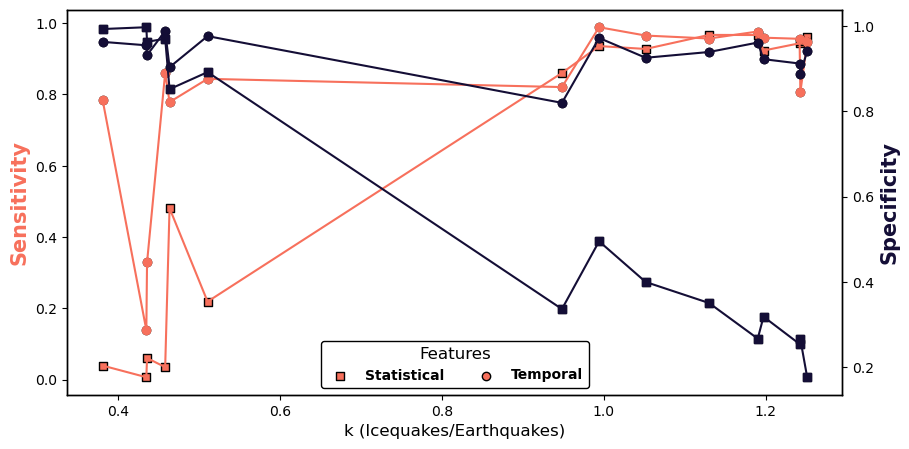

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [10,5])
ax.scatter(ratio[order],np.array(sens_stat)[order], marker = 's', label = 'Statistical', color = c4, ec= 'k')
ax.plot(ratio[np.argsort(ratio)],np.array(sens_stat)[np.argsort(ratio)], color = c4)

ax.scatter(ratio[order],np.array(sens_temp)[order], marker = 'o', label = 'Temporal', color = c4, ec ='k')
ax.plot(ratio[np.argsort(ratio)],np.array(sens_temp)[np.argsort(ratio)], marker = 'o', color = c4)

legend_properties = {'weight':'bold'}
ax.legend(prop = legend_properties, loc='lower center',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12,
          )
ax.set_ylabel('Sensitivity', fontsize  = 15, fontweight = 'bold', color = c4)
ax.set_xlabel('k (Icequakes/Earthquakes)', fontsize = 12)


ax1 = ax.twinx()
ax1.scatter(ratio[order],np.array(speci_stat)[order], marker = 's', label = 'Statistical', color = c1, ec = 'k')
ax1.plot(ratio[np.argsort(ratio)],np.array(speci_stat)[np.argsort(ratio)], marker = 's', label = 'Statistical', color = c1)

ax1.scatter(ratio[order],np.array(speci_temp)[order], marker= 'o', label = 'Temporal', color = c1, ec = 'k')
ax1.plot(ratio[np.argsort(ratio)],np.array(speci_temp)[np.argsort(ratio)], marker= 'o', label = 'Temporal', color = c1)
ax1.set_ylabel('Specificity', fontsize  = 15, fontweight = 'bold', color = c1)



"""
legend_properties = {'weight':'bold'}
#ax[1].legend(prop = legend_properties, loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12,
ax[1].set_ylabel('Specificity', fontsize  = 15, fontweight = 'bold')
ax[1].set_xlabel('k (Icequakes/Earthquakes)', fontsize = 15, fontweight = 'bold')

# Get the x-axis tick labels
xtick_labels = ax[0].get_xticklabels()

# Set the font weight of the tick labels to bold
for label in xtick_labels:
    label.set_weight("bold")
    
# Get the x-axis tick labels
xtick_labels = ax[1].get_xticklabels()

# Set the font weight of the tick labels to bold
for label in xtick_labels:
    label.set_weight("bold")
    
"""
    
    
# Get the x-axis tick labels
#ytick_labels = ax.get_yticklabels()

# Set the font weight of the tick labels to bold
#for label in ytick_labels:
#    label.set_weight("bold")
    
# Get the x-axis tick labels
#ytick_labels = ax[1].get_yticklabels()


# Show the plot
plt.show()


## Plotting the Duration

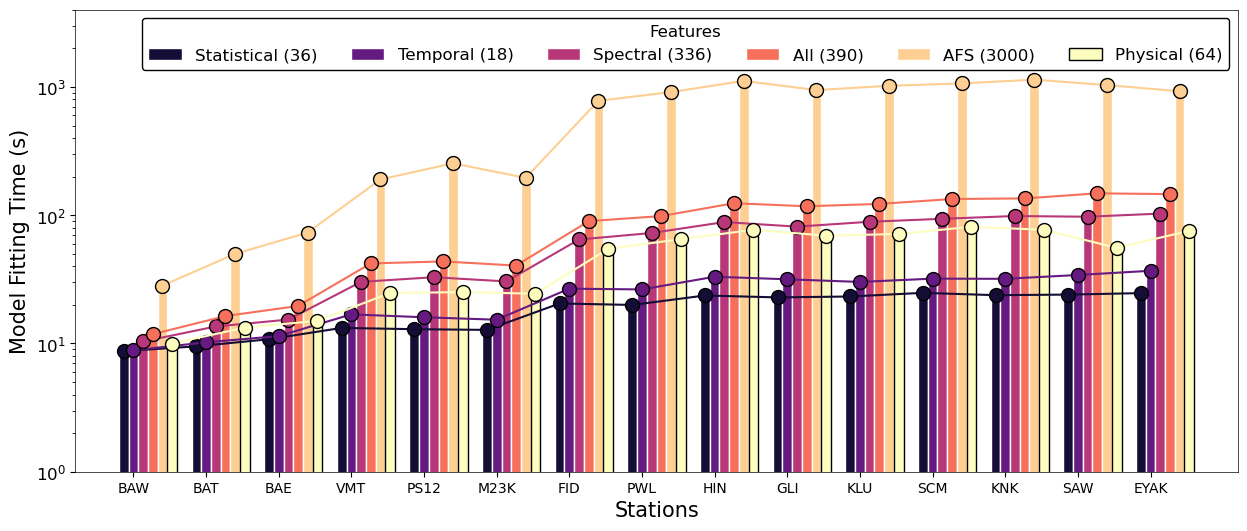

In [52]:
a1 = np.array(dur_stat)*100
a2 = np.array(dur_temp)*100
a3 = np.array(dur_spec)*100
a4 = np.array(dur_all)*100
a5 = np.array(dur_afs)*100
a6 = np.array(dur_phy)*100


plt.style.use('default')
plt.rcParams['axes.linewidth'] = 0.5


cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)



# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(15, 6), facecolor='white')
 



# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, a1[order], color =c1, width = barWidth,
        label ='Statistical (36)',edgecolor='w')
plt.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal (18)',edgecolor='w')
plt.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral (336)',edgecolor='w')
plt.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All (390)',edgecolor='w')
plt.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS (3000)',edgecolor='w')
plt.bar(br6, a6[order], color =c6, width = barWidth,
         label ='Physical (64)',edgecolor='k')

v = np.vstack((a1[order],a2[order]))
X = [br1, br2]
c= [c2,c5]
#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])




plt.plot(br1, a1[order], marker = 'o',mec = 'k', ms = 10, color=c1)
plt.plot(br2, a2[order], marker = 'o',mec = 'k', ms = 10, color=c2) 
plt.plot(br3, a3[order], marker = 'o',mec = 'k', ms = 10, color=c3)
plt.plot(br4, a4[order], marker = 'o',mec = 'k', ms = 10, color=c4)
plt.plot(br5, a5[order], marker = 'o',mec = 'k', ms = 10, color=c5)
plt.plot(br6, a6[order], marker = 'o',mec = 'k', ms = 10, color = c6)
# Adding Xticks
plt.xlabel('Stations', fontsize = 15)

plt.ylabel('Model Fitting Time (s)', fontsize = 15)
plt.yticks(np.arange(0,1000,100), fontsize=12)
plt.xticks([1.5*r + barWidth for r in range(len(a1))],stations[order])
plt.ylim(1,4000)
plt.xlim(-1,23)
plt.legend(loc='upper right',ncol=6, facecolor='white', framealpha=1, edgecolor='black', fontsize=12, title ='Features', title_fontsize=12)
#plt.show()

plt.yscale('log')
#plt.savefig('Manuscript_Figures/Features_Performance_Comparison_averaged.eps')








## Measuring performance with balanced classes as input

In [53]:
## Computing the accuracy, sensitivity, specificity and duration across different feature types of 1 minute in duration. 



acc_spec = []
sens_spec = []
speci_spec = []
dur_spec = []


acc_temp = []
sens_temp = []
speci_temp = []
dur_temp = []

acc_stat = []
sens_stat = []
speci_stat = []
dur_stat = []

acc_all = []
sens_all = []
speci_all = []
dur_all = []

acc_afs = []
sens_afs = []
speci_afs = []
dur_afs = []


acc_phy = []
sens_phy = []
speci_phy = []
dur_phy = []


for i in tqdm(range(len(stations))):
    
    # Extract statistical features
    X1 = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Tsfel_features_1_25_'+stations[i]+'.csv')
    y1 = X1['label']
    
    X_stat = X1.loc[:,stat_features]
    o1, o2, o3, o4 = forest_test_balanced(X_stat, y1)
    acc_stat.append(o1)
    sens_stat.append(o2)
    speci_stat.append(o3)
    dur_stat.append(o4)
    
    
    # Extract temporal features
    X_temp = X1.loc[:,temp_features]
    o1, o2, o3, o4 = forest_test_balanced(X_temp, y1)
    acc_temp.append(o1)
    sens_temp.append(o2)
    speci_temp.append(o3)
    dur_temp.append(o4)
    
    # Extract spectral features
    X_spec = X1.loc[:, spec_features]
   
    o1, o2, o3, o4 = forest_test_balanced(X_spec, y1)
    acc_spec.append(o1)
    sens_spec.append(o2)
    speci_spec.append(o3)
    dur_spec.append(o4)
    
    
    ## Stacking all features
    X = X1.drop(['label','serial_no'], axis = 1).dropna(axis = 1)
    o1, o2, o3, o4 = forest_test_balanced(X, y1)
    acc_all.append(o1)
    sens_all.append(o2)
    speci_all.append(o3)
    dur_all.append(o4)
    
    
    ## AFS Features
    Xr = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/spectrum_features/Z/spectrum_features_1minute/Z_1_25/"+stations[i]+".txt")
    yr = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/spectrum_features/Z/spectrum_features_1minute/Z_1_25/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test_balanced(Xr, yr)
    acc_afs.append(o1)
    sens_afs.append(o2)
    speci_afs.append(o3)
    dur_afs.append(o4)
    
    
    ## Physical Features.
    
    Xp = pd.read_csv('/home/ak287/Icequakes_vs_Tectonicquakes/Extracted_Features/Physical_features_1_25_'+stations[i]+'.csv')
    yp = Xp['label']
    Xp = Xp.drop(['label','serial_no'], axis = 1).dropna(axis = 1)
    
    
    # Replace infinite values with a large finite value
    Xp.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)

    # Alternatively, you can drop rows with NaN or infinite values
    Xp = Xp.replace([np.inf, -np.inf], np.nan).dropna()

    
    scaler = StandardScaler()
    
    feature_columns = Xp.columns
    X_scaled = scaler.fit_transform(Xp)
    X_stand = pd.DataFrame(X_scaled, columns=feature_columns).dropna(axis = 1)
    
    o1, o2, o3, o4 = forest_test_balanced(X_stand, yp)
    acc_phy.append(o1)
    sens_phy.append(o2)
    speci_phy.append(o3)
    dur_phy.append(o4)
    

  0%|          | 0/15 [00:00<?, ?it/s]

No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
  7%|▋         | 1/15 [00:01<00:23,  1.69s/it]

No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
 13%|█▎        | 2/15 [00:02<00:18,  1.45s/it]

No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 20%|██        | 3/15 [00:03<00:15,  1.25s/it]

No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083


 27%|██▋       | 4/15 [00:19<01:17,  7.01s/it]

No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484


 33%|███▎      | 5/15 [00:31<01:25,  8.58s/it]

No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047


 40%|████      | 6/15 [00:47<01:40, 11.18s/it]

No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980


 47%|████▋     | 7/15 [01:05<01:46, 13.34s/it]

No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121


 53%|█████▎    | 8/15 [01:22<01:42, 14.67s/it]

No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100


 60%|██████    | 9/15 [01:41<01:35, 15.96s/it]

No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
 67%|██████▋   | 10/15 [01:44<01:00, 12.03s/it]

No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
 73%|███████▎  | 11/15 [01:47<00:37,  9.34s/it]

No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588


 80%|████████  | 12/15 [02:01<00:32, 10.67s/it]

No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020


 87%|████████▋ | 13/15 [02:18<00:24, 12.39s/it]

No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:899: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_


No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038


 93%|█████████▎| 14/15 [02:35<00:13, 13.88s/it]

No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 15/15 [02:38<00:00, 10.56s/it]

No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420


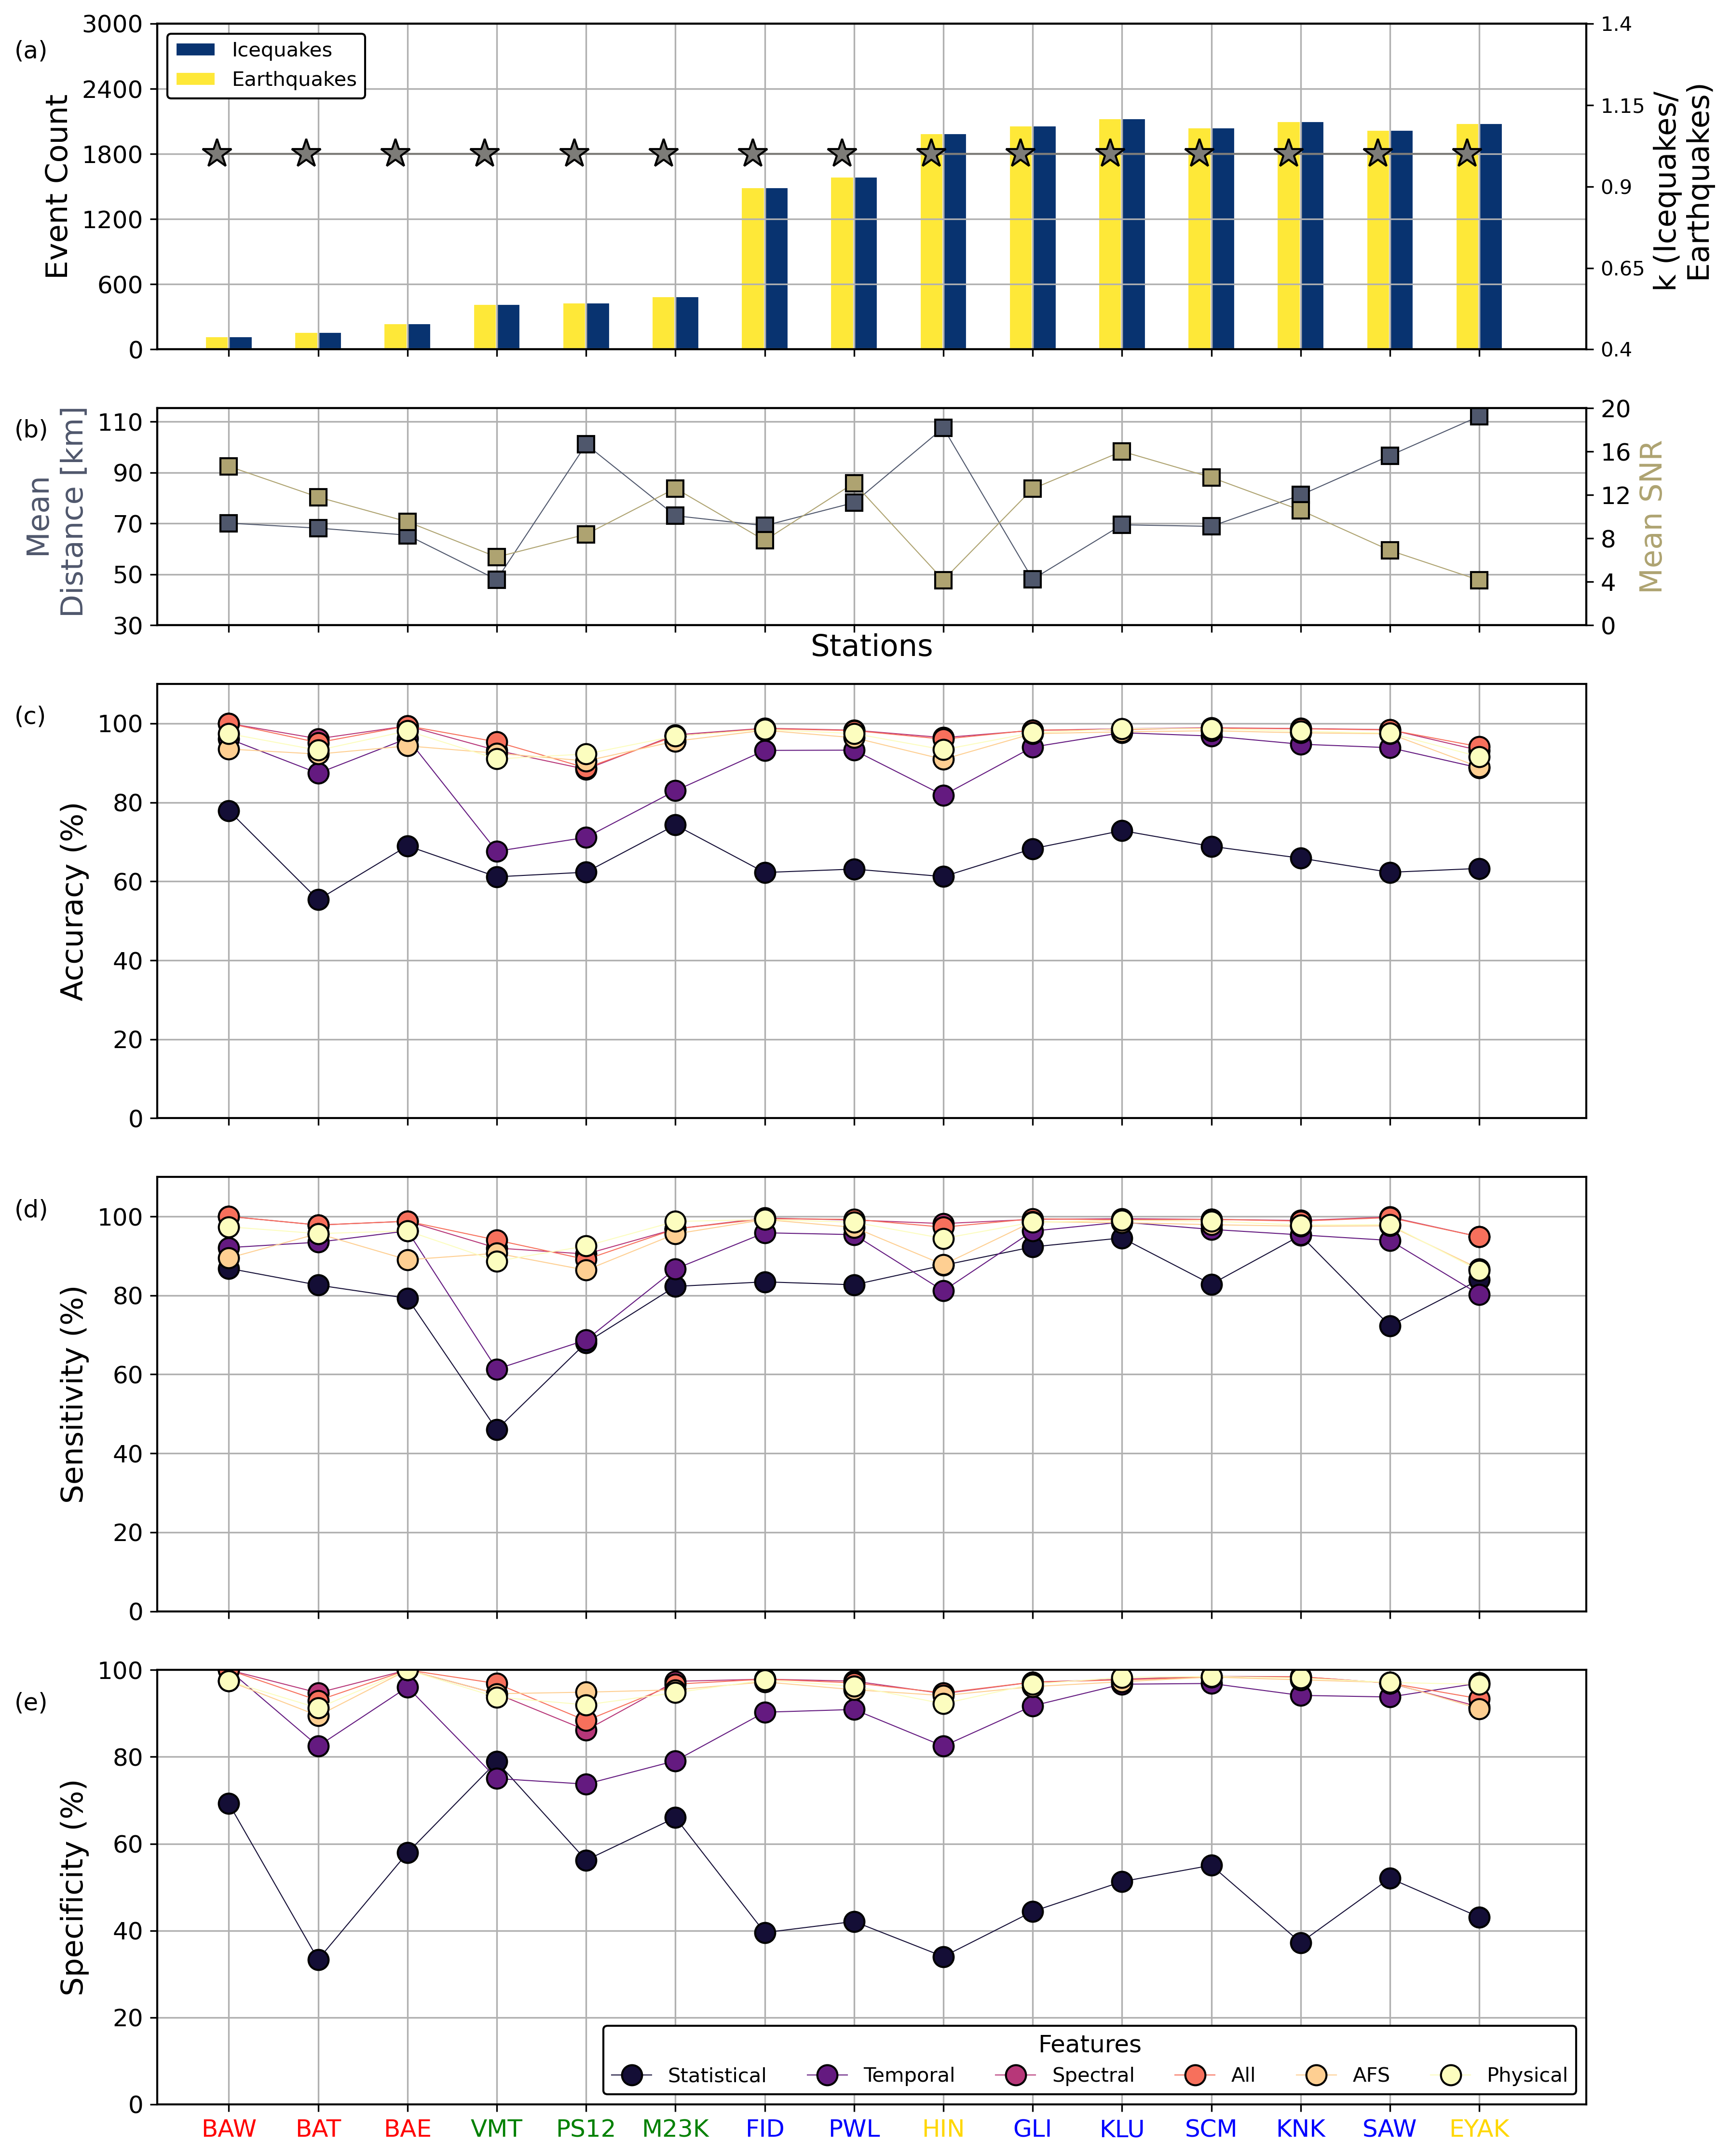

In [57]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 1

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12,15), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1.5,1,2,2,2]}, facecolor ='white', dpi = 300)


# Add labels to subplots
labels = ['(a)', '(b)', '(c)', '(d)','(e)']
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 0.95, labels[i], transform=ax.transAxes,
            fontsize=12, va='top')

(ax,ax1, ax2, ax3, ax4) = axs
a1 = len(stns)


## Extracting colors from a colormap to maintain a constant color scheme
cmap = matplotlib.cm.get_cmap('cividis')
c1_cb = cmap(0.1)
c2_cb = cmap(0.3)
c3_cb = cmap(0.5)
c4_cb = cmap(0.7)
c5_cb = cmap(0.9)
c6_cb = cmap(1.0)




## Extracting colors from a colormap to maintain a constant color scheme
cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)


# set width of bar
barWidth = 0.2


# Set position of bar on X axis
br1 = 1.5*np.arange(a1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]



ratio = np.ones(15)

#################                
# Setting up the first axes
##############
ax.set_xlim(0,15)
ax_t = ax.twinx()
ax_t.plot(br1, ratio[order], marker = '*', mec = 'k', ms = 15, color = c3_cb, linewidth = 1)
ax_t.set_yticks(np.linspace(0.4,1.4,5))
ax_t.set_yticklabels([str(i) for i in np.linspace(0.4,1.4,5)],fontsize=10)
ax_t.set_ylabel('k (Icequakes/ \n Earthquakes)', fontsize=15, color= 'k')






ax.bar(br3, min_events[order], color = c1_cb, width = 0.4,
     label ='Icequakes',edgecolor='w')
ax.bar(br1, min_events[order], color = c6_cb, width = 0.4,
     label ='Earthquakes',edgecolor='w')

#ax.bar(np.arange(15)+0.5, total_events[order], width=0.6)
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12)
ax.set_ylabel('Event Count', fontsize=15)
ax.legend(loc='upper left',ncol=1, facecolor='white', framealpha=1, edgecolor='black', fontsize=10)













#########
# Setting up second axes -- plotting accuracies
########


a1 = np.array(acc_stat)*100
a2 = np.array(acc_temp)*100
a3 = np.array(acc_spec)*100
a4 = np.array(acc_all)*100
a5 = np.array(acc_afs)*100
a6 = np.array(acc_phy)*100




# Make the plot

"""
ax1.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax1.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax1.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax1.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax1.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')
         
"""

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])




ax2.plot(br2, a1[order], marker = 'o', mec = 'k', ms  = 10, label ='Statistical',lw = 0.5, color=c1)
ax2.plot(br2, a2[order], marker = 'o',mec = 'k', ms  = 10, label = 'Temporal', lw = 0.5, color=c2) 
ax2.plot(br2, a3[order], marker = 'o',mec = 'k', ms  = 10, label = 'Spectral', lw = 0.5, color=c3)
ax2.plot(br2, a4[order], marker = 'o',mec = 'k', ms  = 10, label = 'All', lw = 0.5, color=c4)
ax2.plot(br2, a5[order], marker = 'o',mec = 'k',ms  = 10, label = 'AFS', lw = 0.5, color=c5)
ax2.plot(br2, a6[order], marker = 'o', mec = 'k', ms  = 10, label = 'Physical', lw = 0.5, color = c6)


# Adding Xticks
#ax1.set_title('Accuracy', fontweight ='bold', fontsize = 15)
ax2.set_ylabel('Accuracy (%)', fontsize = 15)
ax2.set_yticks(ticks = np.arange(0,120,20))
ax2.set_yticklabels(labels = [str(i) for i in np.arange(0,120,20)], fontsize=12)
ax2.set_ylim(0,110)
ax2.set_xlim(-1,23)
#legend_properties = {'weight':'bold'}
#ax2.legend( loc='lower right',ncol=3, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)








###############
# Setting up third axes - plotting sensitivities
##############

a1 = np.array(sens_stat)*100
a2 = np.array(sens_temp)*100
a3 = np.array(sens_spec)*100
a4 = np.array(sens_all)*100
a5 = np.array(sens_afs)*100
a6 = np.array(sens_phy)*100




# Make the plot
"""
ax2.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax2.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax2.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax2.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax2.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')
"""


#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax3.plot(br2, a1[order], marker = 'o', mec = 'k', ms  = 10, label ='Statistical',lw = 0.5, color=c1)
ax3.plot(br2, a2[order], marker = 'o',mec = 'k', ms  = 10, label = 'Temporal', lw = 0.5, color=c2) 
ax3.plot(br2, a3[order], marker = 'o',mec = 'k', ms  = 10, label = 'Spectral', lw = 0.5, color=c3)
ax3.plot(br2, a4[order], marker = 'o',mec = 'k', ms  = 10, label = 'All', lw = 0.5, color=c4)
ax3.plot(br2, a5[order], marker = 'o',mec = 'k',ms  = 10, label = 'AFS', lw = 0.5, color=c5)
ax3.plot(br2, a6[order], marker = 'o', mec = 'k', ms  = 10, label = 'Physical', lw = 0.5, color = c6)

# Adding Xticks
#ax2.set_title('Sensitivity', fontweight ='bold', fontsize = 15)
ax3.set_ylabel('Sensitivity (%)',  fontsize = 15)
ax3.set_yticks(ticks = np.arange(0,120,20))
ax3.set_yticklabels(labels = [str(i) for i in np.arange(0,120,20)], fontsize=12)
ax3.set_ylim(0,110)
ax3.set_xlim(-1,23)
#legend_properties = {'weight':'bold'}
#ax3.legend( loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)















###############
# Setting up fourth axes - plotting specificity
##############

a1 = np.array(speci_stat)*100
a2 = np.array(speci_temp)*100
a3 = np.array(speci_spec)*100
a4 = np.array(speci_all)*100
a5 = np.array(speci_afs)*100
a6 = np.array(speci_phy)*100






ax4.plot(br2, a1[order], marker = 'o', mec = 'k', ms  = 10, label ='Statistical',lw = 0.5, color=c1)
ax4.plot(br2, a2[order], marker = 'o',mec = 'k', ms  = 10, label = 'Temporal', lw = 0.5, color=c2) 
ax4.plot(br2, a3[order], marker = 'o',mec = 'k', ms  = 10, label = 'Spectral', lw = 0.5, color=c3)
ax4.plot(br2, a4[order], marker = 'o',mec = 'k', ms  = 10, label = 'All', lw = 0.5, color=c4)
ax4.plot(br2, a5[order], marker = 'o',mec = 'k',ms  = 10, label = 'AFS', lw = 0.5, color=c5)
ax4.plot(br2, a6[order], marker = 'o', mec = 'k', ms  = 10, label = 'Physical', lw = 0.5, color = c6)


# Adding Xticks
#ax3.set_title('Specificity', fontweight ='bold', fontsize = 15)
ax4.set_ylabel('Specificity (%)', fontsize = 15)
ax4.set_yticks(ticks = np.arange(0,120,20))
ax4.set_yticklabels(labels = [str(i) for i in np.arange(0,120,20)], fontsize=12)
ax4.set_ylim(0,100)
ax4.set_xlim(-1,23)
#legend_properties = {'weight':'bold'}
ax4.legend( loc='lower right',ncol=6, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12,
          )

xtick_colors = ['r','r','r','g','g','g','blue','blue','gold','blue','blue','blue','blue','blue','gold']
ax4.set_xticks([1.5*r + barWidth for r in range(len(a1))])
ax4.set_xticklabels(labels = stations[order], fontsize=12, )


# Set the color for each tick label individually
for i, label in enumerate(ax4.get_xticklabels()):
    label.set_color(xtick_colors[i])

    
    
###############
# Setting up fifth axes
##############

ax1.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_array)[order], marker = 's', mec = 'k', ms = 8, linewidth = 0.5, color= c2_cb)
#ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_iq)[order], linewidth = 3, color= c5, label = "Icequakes")
ax1.set_xticks(ticks = [1.5*r + barWidth for r in range(len(a1))])

ax1.set_yticks(ticks = np.arange(30,120,20))
ax1.set_yticklabels(labels = [str(i) for i in np.arange(30,120,20)], fontsize=12)
ax1.set_ylabel(' Mean \n Distance [km]', color = c2_cb, fontsize=15)
#ax2.set_xlim(0,15)
#ax4.legend(loc='lower right',ncol=2,facecolor='white', framealpha=1, edgecolor='black', fontsize=10,  title ='Mean distance (km)', title_fontsize = 10)
ax1.set_xlabel('Stations', fontsize=15)
ax1.xaxis.grid(True)

ax5 = ax1.twinx()
ax5.plot([1.5*r + barWidth for r in range(len(a1))],  np.array(snr_array)[order], marker = 's', mec = 'k', ms = 8, linewidth = 0.5, color= c4_cb)
ax5.set_yticks(np.linspace(0,20,6))
ax5.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12)
ax5.set_ylabel('Mean SNR', color= c4_cb, fontsize=15)

ax.xaxis.grid(True)
ax1.xaxis.grid(True)
ax2.xaxis.grid(True)
ax3.xaxis.grid(True)
ax4.xaxis.grid(True)


ax.yaxis.grid(True)
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
ax3.yaxis.grid(True)
ax4.yaxis.grid(True)

fig.tight_layout()


## Printing the Average Statistics

In [58]:
print(f'Average Accuracy Statistical Features {np.mean(acc_stat)}')
print(f'Average Accuracy Temporal Features {np.mean(acc_temp)}')
print(f'Average Accuracy Spectral Features {np.mean(acc_spec)}')
print(f'Average Accuracy AFS Features {np.mean(acc_afs)}')
print(f'Average Accuracy All tsfel Features {np.mean(acc_all)}')
print(f'Average Accuracy Physical Features {np.mean(acc_phy)}')


Average Accuracy Statistical Features 0.6586659789759142
Average Accuracy Temporal Features 0.8902344498759031
Average Accuracy Spectral Features 0.9690953595129772
Average Accuracy AFS Features 0.9475803510188039
Average Accuracy All tsfel Features 0.9699098729951968
Average Accuracy Physical Features 0.9600002929746168


In [59]:
print(f'Average Sensitivity Statistical Features {np.mean(sens_stat)}')
print(f'Average Sensitivity Temporal Features {np.mean(sens_temp)}')
print(f'Average Sensitivity Spectral Features {np.mean(sens_spec)}')
print(f'Average Sensitivity AFS Features {np.mean(sens_afs)}')
print(f'Average Sensitivity All tsfel Features {np.mean(sens_all)}')
print(f'Average Sensitivity Physical Features {np.mean(sens_phy)}')


Average Sensitivity Statistical Features 0.8132532002210855
Average Sensitivity Temporal Features 0.8881126326355374
Average Sensitivity Spectral Features 0.9762714042921818
Average Sensitivity AFS Features 0.9386032061843423
Average Sensitivity All tsfel Features 0.9757974731336552
Average Sensitivity Physical Features 0.9598639477638208


In [60]:
print(f'Average Specificity Statistical Features {np.mean(speci_stat)}')
print(f'Average Specificity Temporal Features {np.mean(speci_temp)}')
print(f'Average Specificity Spectral Features {np.mean(speci_spec)}')
print(f'Average Specificity AFS Features {np.mean(speci_afs)}')
print(f'Average Specificity All tsfel Features {np.mean(speci_all)}')
print(f'Average Specificity Physical Features {np.mean(speci_phy)}')


Average Specificity Statistical Features 0.5068732976024773
Average Specificity Temporal Features 0.8934824597899002
Average Specificity Spectral Features 0.9621116538080938
Average Specificity AFS Features 0.9575463022291363
Average Specificity All tsfel Features 0.9644203270262767
Average Specificity Physical Features 0.960557158741005
